## Analyze A/B Test Results


## Table of Contents
- Introduction
- Data Wrangling
- Part I - Probability
- Part II - A/B Test with Bootstrapping
- Part III - Logistic Regression


<a id='intro'></a>
### Introduction

Our client, an e-commerce company, has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product.

We will perform an A/B test to understand if this company should implement the new page design or keep the old one.  In addition, we will apply other statistical methods such as probability and logistic regression to help cross-check our results.  

<a id='wrangle'></a>
### Data Wrangling

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('ab_data.csv') #Read the file and store it in df

In [3]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


a. The number of rows in the dataset.

In [4]:
df.shape[0]

294478

b. The number of unique users in the dataset.

In [5]:
df.user_id.nunique()

290584

c. The proportion of users converted.

In [6]:
df[df.converted == 1].user_id.nunique() / df.user_id.nunique()

0.12104245244060237

d. The number of times the `new_page` and `treatment` don't match.

In [7]:
df[df.landing_page == 'new_page'].group.value_counts()[1] + df[df.landing_page == 'old_page'].group.value_counts()[1] # sum of new_page that is incorrectly labled as 'control' and old_page that is incorrectly labled as 'treatment'

3893

e. Check missing value.

In [8]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

f. Drop rows where **new_page** is incorrectly labled as 'control' and **old_page** is incorrectly labled as 'treatment'

In [9]:
df2 = df.drop(df[((df.landing_page == 'new_page') & (df.group == 'control')) | ((df.landing_page == 'old_page') & (df.group == 'treatment'))].index)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

g. The number of unique user_id in df2?

In [11]:
df2.user_id.nunique()

290584

h. Duplicate user_id? 

In [12]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove duplicate user_id

In [13]:
df2.drop_duplicates(subset = 'user_id', inplace = True)

In [14]:
# Double check if dup has been removed
df2[df2.user_id.duplicated()].user_id

Series([], Name: user_id, dtype: int64)

<a id='probability'></a>
### Part I - Probability

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2.query('group == "control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2.query('group == "treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
new_page_prob = df2.landing_page == 'new_page' 
new_page_prob.mean()

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

In [19]:
df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean() #prob of treatment conversion - prob of control conversion   

-0.0015782389853555567

Given the difference in conversion rate rate between the new page and old page is -0.001578, it does not suggest that there is sufficient evidence where the new treatment page leads to more conversions.  If anything, the number is negative which means that the probability of conversion is actually higher with the old control group.  

<a id='ab_test'></a>
### Part II - A/B Test with Bootstrapping

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate ($\alpha$) of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$H_{0}$ : $p_{new}$ - $p_{old}$ $\leq$ 0

$H_{1}$ : $p_{new}$ - $p_{old}$ $\gt$ 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [20]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [22]:
n_new = df2[df2.group == 'treatment'].shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [23]:
n_old = df2[df2.group == 'control'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.choice([0,1], size = n_new, p=[1-p_new, p_new])

In [25]:
new_page_converted.shape

(145310,)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.choice([0,1], size= n_old, p=[1-p_old, p_old])

In [27]:
old_page_converted.shape

(145274,)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [28]:
new_page_converted.mean() - old_page_converted.mean()

0.0006654041880582023

#### Bootstrapping

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [29]:
p_diffs = [] #bootstrapping 10,000 iteractions
for i in range(10000):
    new_page_converted2 = np.random.choice([0,1], size = n_new, p=[1-p_new, p_new])
    old_page_converted2 = np.random.choice([0,1], size = n_new, p=[1-p_new, p_new])
    difference = new_page_converted2.mean() - old_page_converted2.mean()
    p_diffs.append(difference)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

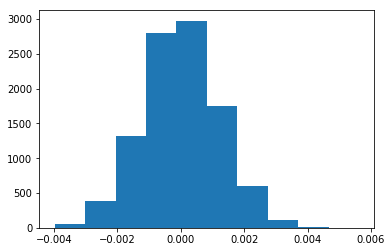

In [30]:
# Convert to numpy array
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

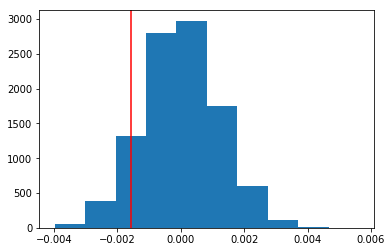

In [31]:
a_diffs = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean() #the same code used in 3e
plt.hist(p_diffs)
plt.axvline(a_diffs, color='red');

In [32]:
p_val = (np.array(p_diffs) > a_diffs).mean()
p_val

0.9103

k. Please explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The number we just computed in **j** is known as the p-value.  The smaller the p-value, the stronger the evidence is against our null hypthoensis.  And the rule of thumb is to reject $H_{0}$ if the p-value is $\leq$ ($\alpha$), which is defined as 0.05 in the beginning of the A/B test.

Therefore, with a p value of 0.904, we would fail to reject $H_{0}$.  This suggests that the difference is not statistically significant.  In other words, the new page design does not yield to a higher conversion rate than the old one.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"').converted.sum()
convert_new = df2.query('group == "treatment"').converted.sum()
n_old =  df2.query('group == "control"').shape[0]
n_new =  df2.query('group == "treatment"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [34]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new],[n_old, n_new], alternative = 'smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

As stated earlier, the significance level ($\alpha$) we use for this A/B test is 5%, which is equalivent to a 95% confidence level with a z-score of 1.645 in the right tailed test.  Therefore, we would fail to reject $H_{0}$ as the calculated z-score of 1.311 (in **m.**) is less then the critical value of 1.645.

P-value here also yields the same conclusion - we fail to reject $H_{0}$ as 0.905 is greater than $\alpha$ (0.05).

Therefore, the z-score and p-value we computed here do agree with the findings in parts  **j.** and **k.**.

<a id='regression'></a>
### Part III - Regression

`1.` In this final part, we will demonstrate that the results we achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

We would use a logistic regression model, because the dependable variable only takes on 2 values - conversion or no conversion.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
df3 = df2.copy() #creating a new df exclusively for regression analysis

In [36]:
df3['intercept'] = 1
df3['ab_page'] = pd.get_dummies(df3['group']).treatment

In [37]:
df3.head() #quick check to make sure the new columns are added correctly

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [38]:
logit_mod = sm.Logit(df3['converted'], df3[['intercept','ab_page']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [39]:
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 15 Jan 2020   Pseudo R-squ.:               8.077e-06
Time:                        18:23:01   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

The p-value associated with ab_page is 0.19, which suggest that ab_page is not 
statistically signficant for predicting the converted rate.  The p-value is different here because in the case for regression, the null hypotheses means that the population slope is equal to zero while the alternative hypotheses means that the population slope is not equal to zero.

$H_{0} : \beta_{1} = 0$

$H_{1} : \beta_{1} \neq  0$

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

As the p-value suggested, ab_page alone is not statistically significant for predicting the converted rate. So it is a good idea to incorporate other x-variables to the regression model.  However, adding too many items could over complicate our prediction model and does not necessarily help improve the R-squared value.  In addition, issues such as multicollinearity could arise with multiple linear regression models.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [40]:
cdf = pd.read_csv('countries.csv')

In [41]:
cdf.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [42]:
df4 = df3.join(cdf.set_index('user_id'), on='user_id')

In [43]:
df4.country.unique() #find out all the variables under the country column

array(['US', 'CA', 'UK'], dtype=object)

In [44]:
df4[['CA','UK','US']] = pd.get_dummies(df4['country'])
df4.head(20)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US,0,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US,0,0,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,0


In [45]:
logit_mod = sm.Logit(df4['converted'], df4[['intercept','ab_page', 'CA','UK']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 15 Jan 2020   Pseudo R-squ.:               2.323e-05
Time:                        18:23:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

Similiar to our previous result, p-values for all the x variables are still more than 0.05.  This means that even if we added country as another variable to our linear model, it is still not statistically signficant for predicting conversions.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [46]:
df4['ab_page_CA'] = df4['ab_page'] * df4['CA'] #interaction between ab_page and CA
df4['ab_page_UK'] = df4['ab_page'] * df4['UK'] #interaction between ab_page and UK

In [47]:
logit_mod = sm.Logit(df4['converted'], df4[['intercept','ab_page', 'CA','UK','ab_page_CA','ab_page_UK']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 15 Jan 2020   Pseudo R-squ.:               3.482e-05
Time:                        18:23:06   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
ab_page_CA    -0.0469      0.054     -0.872      0.383      -0.152       0.059
ab_page_UK     0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

We have incorporated the interaction between ab_page and CA/UK here.  However similiar to previous results, p-values for the interaction terms are still higher than 0.05.  Once again, we would fail to reject $H_{0}$.  This means that the interaction between page and country also do not have a significant effect on conversion. 

In [48]:

from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0